In [12]:
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, linear_model
import statsmodels.api as sm
from tqdm import tqdm


from MRT_instance import MRT_instance
from selectinf.lasso import lasso
from selectinf.Utils.base import selected_targets, selected_targets_WCLS

import rpy2
import rpy2.robjects as robjects

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
# Activate automatic conversion between numpy arrays and R matrices/vectors
numpy2ri.activate()
selectiveInference = importr('selectiveInference')

import warnings
# suppress warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'selectinf.lasso'

In [2]:
import sys
print(sys.executable)

/Users/bakso/anaconda3/envs/py39/bin/python


In [ ]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
# os.environ['R_HOME'] = '/usr/local/bin/R'

! pip install rpy2

# Simulation: Comparing post-selection CIs for different methods

In [ ]:
pip install pandas

## Rough Try Out

In [8]:
# Example data
X = np.random.rand(100, 10)  # 100 samples, 10 features
y = np.random.rand(100)  # Target variable
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X,y)
print(clf.coef_)

[-0.  0.  0.  0. -0. -0. -0. -0. -0.  0.]


In [4]:
N = 300
beta_11 = 4
X, Y, beta, A = MRT_instance(N=N, beta_11=beta_11)[:4]
print(beta)

n, p = X.shape
print(X.shape)
sigma_ = np.std(Y)

if n > (2 * p):
    dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
else:
    dispersion = sigma_ ** 2
    
print(np.sqrt(dispersion))
print(sigma_)

[0.8 0.8 0.8 0.8 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
(1400, 30)
3.483169949199358
3.734656666652022


In [15]:
scaling = np.mean(X.std(0) * np.sqrt(N))
scaling

11.919865516489255

In [5]:
# Standardize the features
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X.std())
print(X_scaled.std())
print(Y.std())
print(np.mean(Y))

0.6912146323263823
0.9999999999999999
3.5714674013383254
-0.035621163226775374


In [7]:
eps = np.random.standard_normal((n, 2000)) * Y.std()

W = 0.5 * np.median(np.abs(X.T.dot(eps)).max(1)) #Weights 
print(W)
lambda_value = 0.5 * np.median(np.abs(X.T.dot(eps)).max(1)) #Poly 
print(lambda_value)

175.43664048791643
175.43664048791643


In [8]:
inst, const = MRT_instance, lasso.gaussian
randomizer_scale = 0.7
conv = const(X,
             Y,
             W,
             ridge_term=0.,
             randomizer_scale=randomizer_scale * np.sqrt(dispersion))

signs1 = conv.fit()
nonzero1 = signs1 != 0
beta_target1 = np.linalg.pinv(X[:, nonzero1]).dot(X.dot(beta))
print(beta_target1)
print(nonzero1.sum())

if nonzero1.sum() > 0:
    
    conv.setup_inference(dispersion=dispersion)

    target_spec = selected_targets_WCLS(conv.loglike,
                                        A,
                                       conv.observed_soln,
                                       K = conv.K,
                                       dispersion= dispersion)

    result_exact = conv.inference(target_spec)

    intervals = np.asarray(result_exact[['lower_confidence', 'upper_confidence']])
    lci = intervals[:, 0]
    uci = intervals[:, 1]
    coverage1 = (lci < beta_target1) * (uci > beta_target1)
    length1 = uci - lci
    
print(intervals)
print(length1)

[ 8.00000000e-01  8.00000000e-01  8.00000000e-01  8.00000000e-01
  8.00000000e-01 -1.23165367e-16  7.44196371e-16  1.03974988e-16]
8
[[ -9.05562224   2.21173608]
 [  1.47900366  14.15755623]
 [ -6.45054326   5.6469963 ]
 [-12.00390649   6.45193436]
 [ -2.56861115   5.57349479]
 [ -7.02913802   4.36671068]
 [-13.15534265   0.71894827]
 [ -0.92724822  18.35771235]]
[11.26735832 12.67855257 12.09753956 18.45584085  8.14210593 11.3958487
 13.87429093 19.28496057]


In [219]:
print(coverage)
print(length)
print(ci)
print(beta_target)
print(beta)
print(nonzero.sum())

[ True  True  True  True  True]
[inf inf inf inf inf]
[[2.46751391        inf]
 [2.47848546        inf]
 [2.44635579        inf]
 [2.43636942        inf]
 [2.44974234        inf]]
[4. 4. 4. 4. 4.]
[4. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
5


In [ ]:
print(np.mean(coverage))

## Comparing polyhedral with other methods

In [2]:
def compwl_inf(N=300,
               beta_11=4.4,
               randomizer_scale=1.):
    
    while True:
        
        inst, const = MRT_instance, lasso.gaussian
        
        X, Y, beta, A = MRT_instance(N=N, beta_11=beta_11)[:4]
        
        n, p = X.shape
        sigma_ = np.std(Y)
        
        if n > (2 * p):
            dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
        else:
            dispersion = sigma_ ** 2
        
        eps = np.random.standard_normal((n, 2000)) * Y.std()
        W = 0.7 * np.median(np.abs(X.T.dot(eps)).max(1))
        
        # Polyhedral Method
        
        # Standardize the features
        # scaler = preprocessing.StandardScaler()
        # X_scaled = scaler.fit_transform(X)
        # beta_scaled = beta * scaler.scale_
        
        lambda_value = 0.5 * np.median(np.abs(X.T.dot(eps)).max(1))
        # print(lambda_value)
        
        # Fit the standard Lasso without an intercept
        slf = linear_model.Lasso(alpha=lambda_value/n, fit_intercept=False)
        
        slf.fit(X, Y)
        # print(slf.coef_)
        nonzerop = slf.coef_ != 0
        
        
        beta_targetp = np.linalg.pinv(X[:, nonzerop]).dot(X.dot(beta))
        # print(beta_targetp)
        # print(nonzerop.sum())        
        
        
        # Apply Polyhedral method from selectiveInference package in R 
        results = selectiveInference.fixedLassoInf(X, Y, slf.coef_, lam=lambda_value, sigma=np.sqrt(dispersion))
        pvals = np.array(results.rx2('pval'))
        pci = np.array(results.rx2('ci'))
        # print(pci)
        
        if len(pci) == nonzerop.sum():
            plci = pci[:, 0]
            puci = pci[:, 1]
            coveragep = (plci < beta_targetp) * (puci > beta_targetp)
            lengthp = puci - plci
            # inf_indices = np.isinf(length2)
            # coverage2f = np.delete(coverage2, np.where(inf_indices))
            
            # Randomized LASSO 
            randomizer_scale = 1.
            conv = const(X,
                         Y,
                         W,
                         ridge_term=0.,
                         randomizer_scale=randomizer_scale * np.sqrt(dispersion))
        
            signs1 = conv.fit()
            nonzero1 = signs1 != 0
            # print(nonzero1.sum())
            
            if nonzero1.sum() > 0:
                
                beta_target1 = np.linalg.pinv(X[:, nonzero1]).dot(X.dot(beta))
                # print(beta_target1)
                conv.setup_inference(dispersion=dispersion)
                # print(dispersion)
                # print(conv.observed_soln)
        
                target_spec = selected_targets_WCLS(conv.loglike,
                                                    A,
                                                    conv.observed_soln,
                                                    K = conv.K,
                                                    dispersion=dispersion)
        
                result_exact = conv.inference(target_spec)
        
                intervals = np.asarray(result_exact[['lower_confidence', 'upper_confidence']])
                intervals = intervals
                # print(intervals)
                lci = intervals[:, 0]
                uci = intervals[:, 1]
                coverage1 = (lci < beta_target1) * (uci > beta_target1)
                length1 = (uci - lci)
                
                lower, upper = [], []
                ntarget = nonzero1.sum()
                for m in range(ntarget):
                    observed_target_uni = target_spec.observed_target[m]
                    cov_target_uni = np.sqrt(np.diag(target_spec.cov_target))[m]
                    level = 0.9
                    u = norm.ppf(1 - (1 - level) / 2)
                    l = norm.ppf((1 - level) / 2)
                    lower.append(l * cov_target_uni + observed_target_uni)
                    upper.append(u * cov_target_uni + observed_target_uni)
            
                lci = np.asarray(lower)
                uci = np.asarray(upper)
            
                coverage2 = (lci < beta_target1) * (uci > beta_target1)
                length2 = uci - lci
                    
                #Data Splitting
                unique_ids = A['id'].unique()
                shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42019).tolist()
            
                # Split the IDs into train and test sets
                test_prop = 0.3
                train_size = int((1 - test_prop) * len(shuffled_ids))
                train_ids = shuffled_ids[:train_size]
                test_ids = shuffled_ids[train_size:]
            
                # Split the dataframe based on these IDs
                A_train = A[A['id'].isin(train_ids)]
                A_test = A[A['id'].isin(test_ids)]
                X_train = np.array(A_train.iloc[:, 2:p+2])
                X_test = np.array(A_test.iloc[:, 2:p+2])
                Y_train = np.array(A_train.iloc[:, p + 2])
                Y_test = np.array(A_test.iloc[:, p + 2])
            
                n_train = X_train.shape[0]
                n_test = X_test.shape[0]
                eps1 = np.random.standard_normal((n_train, 2000)) * Y_train.std()
                # W_train = n_train/(n_train+ n_test) * W
                W_train = 0.7 *  n_train/(n_train+ n_test) * np.median(np.abs(X_train.T.dot(eps1)).max(1))
                
                conv2 = const(X_train,
                              Y_train,
                              W_train,
                              ridge_term=0.,
                              randomizer_scale=0)
            
                signs2 = conv2.fit(perturb=np.zeros(p))
                nonzero2 = signs2 != 0
                
                beta_target2 = np.linalg.pinv(X_test[:, nonzero2]).dot(X_test.dot(beta))
            
                Xf1 = np.array(A_test.iloc[:, 2:-1])
                Xf1 = Xf1[:, nonzero2]
                yf1 = A_test['Y']
                groups = A_test['id']
                
                # fit the GEE model
                model2 = sm.GEE(yf1, Xf1, groups=groups, family=sm.families.Gaussian(), cov_struct=sm.cov_struct.Independence())
                result_split = model2.fit(cov_type='robust')
            
                split_intervals = np.array(result_split.conf_int(alpha=0.1))
            
                lci = split_intervals[:, 0]
                uci = split_intervals[:, 1]
                coverage3 = (lci < beta_target2) * (uci > beta_target2)
                length3 = uci - lci
            
                 # coverage2f,    
                return coveragep, coverage1, coverage2, coverage3, lengthp, length1,  length2, length3

In [13]:
compwl_inf(120, 4)

(array([ True, False,  True,  True,  True,  True,  True,  True,  True]),
 array([ True, False,  True,  True,  True,  True,  True]),
 array([ True, False,  True,  True,  True, False, False]),
 array([ True,  True,  True,  True,  True,  True,  True,  True]),
 array([0.32515256, 0.34731066, 0.32140862, 0.3416604 , 0.32456779,
        1.64657063, 0.84490029, 0.53497598, 0.53413935]),
 array([0.58903957, 0.68793048, 0.66137471, 0.42881503, 0.43189786,
        0.82351503, 0.81710495]),
 array([0.35630767, 0.32180079, 0.33525216, 0.3400856 , 0.32427744,
        0.36507122, 0.34646885]),
 array([0.64584761, 0.54277495, 0.55289784, 0.68527197, 0.61576933,
        0.56047437, 0.67275965, 0.33370246]))

In [4]:
nsim =  500
bcoveragep_1 = []
bcoverage1_1 = []
bcoverage2_1 = []
bcoverage3_1 = []
blengthp_1 = []    
blength1_1 = []
blength2_1 = []
blength3_1 = []
bcoveragep_2 = []
bcoverage1_2 = []
bcoverage2_2 = []
bcoverage3_2 = []
blengthp_2 = []
blength1_2 = []
blength2_2 = []
blength3_2 = []
bcoveragep_3 = []
bcoverage1_3 = []
bcoverage2_3 = []
bcoverage3_3 = []
blengthp_3 = []
blength1_3 = []
blength2_3 = []
blength3_3 = []


# blength1_4 = []
# blength2_4 = []
# blength3_4 = []
# bcoverage1_4 = []
# bcoverage2_4 = []
# bcoverage3_4 = []

for i in tqdm(range(nsim)):
    output1= compwl_inf(N=120, beta_11=1.2)
    output2= compwl_inf(N=120, beta_11=2.4)
    output3= compwl_inf(N=120, beta_11=4.4)
    # output4= compwl_inf(N=300, beta_11=36)
    
    # assert output1 is not None, "The function output is None"
    # assert output2 is not None, "The function output is None"
    # assert output3 is not None, "The function output is None"
    # assert output4 is not None, "The function output is None"
    # and (output4 is not None)
    
    if (output1 is not None) and (output2 is not None) and (output3 is not None) :
    
        coveragep_1, coverage1_1, coverage2_1, coverage3_1, lengthp_1, length1_1, length2_1, length3_1 = output1
        bcoveragep_1.append(np.mean(coveragep_1))
        bcoverage1_1.append(np.mean(coverage1_1))
        bcoverage2_1.append(np.mean(coverage2_1))
        bcoverage3_1.append(np.mean(coverage3_1))
        blengthp_1.append(np.mean(lengthp_1))
        blength1_1.append(np.mean(length1_1))
        blength2_1.append(np.mean(length2_1))
        blength3_1.append(np.mean(length3_1))
        
        coveragep_2, coverage1_2, coverage2_2, coverage3_2, lengthp_2, length1_2, length2_2, length3_2 = output2
        bcoveragep_2.append(np.mean(coveragep_2))
        bcoverage1_2.append(np.mean(coverage1_2))
        bcoverage2_2.append(np.mean(coverage2_2))
        bcoverage3_2.append(np.mean(coverage3_2))
        blengthp_2.append(np.mean(lengthp_2))
        blength1_2.append(np.mean(length1_2))
        blength2_2.append(np.mean(length2_2))
        blength3_2.append(np.mean(length3_2))
        
        coveragep_3, coverage1_3, coverage2_3, coverage3_3, lengthp_3, length1_3, length2_3, length3_3 = output3
        bcoveragep_3.append(np.mean(coverage1_3))
        bcoverage1_3.append(np.mean(coverage1_3))
        bcoverage2_3.append(np.mean(coverage2_3))
        bcoverage3_3.append(np.mean(coverage3_3))
        blengthp_3.append(np.mean(length1_1))
        blength1_3.append(np.mean(length1_3))
        blength2_3.append(np.mean(length2_3))
        blength3_3.append(np.mean(length3_3))
        
        # coverage1_4, coverage2_4, coverage3_4, length1_4, length2_4, length3_4 = output4
        # bcoverage1_4.append(np.mean(coverage1_4))
        # bcoverage2_4.append(np.mean(coverage2_4))
        # bcoverage3_4.append(np.mean(coverage3_4))
        # blength1_4.append(np.mean(length1_4))
        # blength2_4.append(np.mean(length2_4))
        # blength3_4.append(np.mean(length3_4))
    


100%|██████████| 500/500 [36:12<00:00,  4.34s/it]


In [ ]:
#0.8
print("SI Coverage", np.mean(bcoverage1_1))
print("Polyhedral Coverage", np.mean(bcoveragep_1))
print("Naive Coverage", np.mean(bcoverage2_1))
print("Splitting Coverage", np.mean(bcoverage3_1))
print("SI Length", np.mean(blength1_1))
print("Polyhedral Length", np.mean(blengthp_1))
print("Naive Coverage", np.mean(blength2_1))
print("Splitting Length", np.mean(blength3_1))
blengthp_1 = np.array(blengthp_1)
finite_lengthsp = blength2_1[np.isfinite(blengthp_1)]
print("Polyhedral Finite Length", np.mean(finite_lengthsp))
print("Percentage of finite intervals", len(finite_lengthsp)/500)

In [ ]:
#2.4
print("SI Coverage", np.mean(bcoverage1_2))
print("Polyhedral Coverage", np.mean(bcoveragep_2))
print("Naive Coverage", np.mean(bcoverage2_2))
print("Splitting Coverage", np.mean(bcoverage3_2))
print("SI Length", np.mean(blength1_2))
print("Polyhedral Length", np.mean(blengthp_2))
print("Naive Coverage", np.mean(blength2_2))
print("Splitting Length", np.mean(blength3_2))
blengthp_2 = np.array(blengthp_2)
finite_lengths_2 = blength2_2[np.isfinite(blengthp_2)]
print("Polyhedral Finite Length", np.mean(finite_lengths_2))
print("Percentage of finite intervals",len(finite_lengths_2)/500)

In [7]:
#4
print("SI Coverage", np.mean(bcoverage1_3))
print("Polyhedral Coverage", np.mean(bcoveragep_3))
print("Naive Coverage", np.mean(bcoverage2_3))
print("Splitting Coverage", np.mean(bcoverage3_3))
print("SI Length", np.mean(blength1_3))
print("Polyhedral Length", np.mean(blengthp_3))
print("Naive Coverage", np.mean(blength2_3))
print("Splitting Length", np.mean(blength3_3))
blength2_3 = np.array(blength2_3)
finite_lengths_3 = blength2_3[np.isfinite(blength2_3)]
print("Polyhedral Finite Length", np.mean(finite_lengths_3))
print("Percentage of finite intervals",len(finite_lengths_3)/500)

SI Coverage 0.8949285714285714
Polyhedral Coverage 0.8949285714285714
Naive Coverage 0.776118253968254
Splitting Coverage 0.8724882672882672
SI Length 0.558000556703945
Polyhedral Length 0.7743245215184031
Naive Coverage 0.368047522953052
Splitting Length 0.6526222919137175
Polyhedral Finite Length 0.368047522953052
Percentage of finite intervals 1.0


In [8]:
Data_vs_lap = pd.DataFrame({"Selective Coverage (1.2)": bcoverage1_1, "Polyhedral Coverage (1.2)": bcoveragep_1,"Naive Coverage (1.2)": bcoverage2_1, " Split Coverage (1.2)": bcoverage3_1, "Selective CI Lengths (1.2)": blength1_1, "Polyhedral Lengths (1.2)": blengthp_1, "Naive Lengths (1.2)": blength2_1, "Data Splitting CI Lengths (1.2)": blength3_1, "Selective Coverage (2)": bcoverage1_2, "Polyhedral Coverage (2.4)": bcoveragep_2,"Naive Coverage (2.4)": bcoverage2_2, " Split Coverage (2.4)": bcoverage3_2, "Selective CI Lengths (2.4)": blength1_2, "Polyhedral Lengths (2.4)": blengthp_2, "Naive Lengths (2.4)": blength2_2, "Data Splitting CI Lengths (2.4)": blength3_2, "Selective Coverage (4.4)": bcoverage1_3, "Polyhedral Coverage (4.4)": bcoveragep_3,"Naive Coverage (4.4)": bcoverage2_3, " Split Coverage (4.4)": bcoverage3_3, "Selective CI Lengths (4.4)": blength1_3, "Polyhedral Lengths (4.4)": blengthp_3, "Naive Lengths (4.4)": blength2_3, "Data Splitting CI Lengths (4.4)": blength3_3})

Data_vs_lap.to_csv('Data_vs_lap.csv')

In [ ]:
Data_vs_exp = pd.DataFrame({"Selective Coverage (1)": bcoverage1_1, "Polyhedral Coverage (1)": bcoveragep_1,"Naive Coverage (1)": bcoverage2_1, " Split Coverage (1)": bcoverage3_1, "Selective CI Lengths (1)": blength1_1, "Polyhedral Lengths (1)": blengthp_1, "Naive Lengths (1)": blength2_1, "Data Splitting CI Lengths (1)": blength3_1, "Selective Coverage (2)": bcoverage1_2, "Polyhedral Coverage (2)": bcoveragep_2,"Naive Coverage (2)": bcoverage2_2, " Split Coverage (2)": bcoverage3_2, "Selective CI Lengths (2)": blength1_2, "Polyhedral Lengths (2)": blengthp_2, "Naive Lengths (2)": blength2_2, "Data Splitting CI Lengths (2)": blength3_2, "Selective Coverage (8)": bcoverage1_3, "Polyhedral Coverage (8)": bcoveragep_3,"Naive Coverage (8)": bcoverage2_3, " Split Coverage (8)": bcoverage3_3, "Selective CI Lengths (8)": blength1_3, "Polyhedral Lengths (8)": blengthp_3, "Naive Lengths (8)": blength2_3, "Data Splitting CI Lengths (8)": blength3_3})

Data_vs_exp.to_csv('Data_vs_exp.csv')

In [14]:
Data_vn_1 = pd.DataFrame({"Selective Coverage (60)": bcoverage1_1, "Polyhedral Coverage (60)": bcoveragep_1,"Naive Coverage (60)": bcoverage2_1, " Split Coverage (60)": bcoverage3_1, "Selective CI Lengths (60)": blength1_1, "Polyhedral Lengths (60)": blengthp_1, "Naive Lengths (60)": blength2_1, "Data Splitting CI Lengths (60)": blength3_1, "Selective Coverage (90)": bcoverage1_2, "Polyhedral Coverage (90)": bcoveragep_2,"Naive Coverage (90)": bcoverage2_2, " Split Coverage (90)": bcoverage3_2, "Selective CI Lengths (90)": blength1_2, "Polyhedral Lengths (90)": blengthp_2, "Naive Lengths (90)": blength2_2, "Data Splitting CI Lengths (90)": blength3_2, "Selective Coverage (150)": bcoverage1_3, "Polyhedral Coverage (150)": bcoveragep_3,"Naive Coverage (150)": bcoverage2_3, " Split Coverage (150)": bcoverage3_3, "Selective CI Lengths (150)": blength1_3, "Polyhedral Lengths (150)": blengthp_3, "Naive Lengths (150)": blength2_3, "Data Splitting CI Lengths (150)": blength3_3})

Data_vn_1.to_csv('Data_vn_1.csv')

In [ ]:
Data_compoly1 = pd.DataFrame({"Selective Coverage (0.8)": bcoverage1_1, "Polyhedral Coverage (0.8)": bcoverage2_1, " Split Coverage (0.8)": bcoverage3_1, "Selective CI Lengths (0.8)": blength1_1, "Polyhedral Lengths (0.8)": blength2_1, "Data Splitting CI Lengths (0.8)": blength3_1})

Data_compoly2 = pd.DataFrame({"Selective Coverage (1.6)": bcoverage1_2, "Polyhedral Coverage (1.6)": bcoverage2_2, " Split Coverage (1.6)": bcoverage3_2, "Selective CI Lengths (1.6)": blength1_2, "Polyhedral Lengths (1.6)": blength2_2, "Data Splitting CI Lengths (1.6)": blength3_2})

Data_compoly3 = pd.DataFrame({"Selective Coverage (4)": bcoverage1_3, "Polyhedral Coverage (4)": bcoverage2_3, " Split Coverage (4)": bcoverage3_3, "Selective CI Lengths (4)": blength1_3, "Polyhedral Lengths (4)": blength2_3, "Data Splitting CI Lengths (4)": blength3_3})

Data_compoly4 = pd.DataFrame({"Selective Coverage (10)": bcoverage1_4, "Polyhedral Coverage (10)": bcoverage2_4, " Split Coverage (10)": bcoverage3_4, "Selective CI Lengths (10)": blength1_4, "Polyhedral Lengths (10)": blength2_4, "Data Splitting CI Lengths (10)": blength3_4})

## Making Plots

In [29]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

dfsn = pd.read_csv('~/Documents/git/SI-MRT/selectinf/tests/Data_vs_n.csv')
dfse = pd.read_csv('~/Documents/git/SI-MRT/selectinf/tests/Data_vs_exp.csv')
dfsl = pd.read_csv('~/Documents/git/SI-MRT/selectinf/tests/Data_vs_lap.csv')
dfn = pd.read_csv('~/Documents/git/SI-MRT/selectinf/tests/Data_vn_1.csv')

In [38]:
print(dfn[list(dfn.columns)[1:]].mean())

Selective Coverage (60)            0.895688
Polyhedral Coverage (60)           0.779326
Naive Coverage (60)                0.579611
 Split Coverage (60)               0.860814
Selective CI Lengths (60)          0.774325
Polyhedral Lengths (60)                 inf
Naive Lengths (60)                 0.365489
Data Splitting CI Lengths (60)     0.651259
Selective Coverage (90)            0.893721
Polyhedral Coverage (90)           0.810034
Naive Coverage (90)                0.766081
 Split Coverage (90)               0.867072
Selective CI Lengths (90)          0.623058
Polyhedral Lengths (90)                 inf
Naive Lengths (90)                 0.366338
Data Splitting CI Lengths (90)     0.647606
Selective Coverage (150)           0.894929
Polyhedral Coverage (150)          0.894929
Naive Coverage (150)               0.776118
 Split Coverage (150)              0.872488
Selective CI Lengths (150)         0.558001
Polyhedral Lengths (150)           0.774325
Naive Lengths (150)             

In [65]:
# Extracting signal strengths from column names and creating a separate column
signal_strengths = ["1", "2.4", "4.4"]

# Create a new column for signal strengths based on the pattern in column names
data_melted = data.melt(id_vars=["Unnamed: 0"], var_name="Metric", value_name="Value")
data_melted["Signal Strength"] = data_melted["Metric"].str.extract(r"\(([\d.]+)\)").astype(float)

length_df.head(), coverage_df.head()

(   Selective CI Lengths (1)  Polyhedral Lengths (1)  Naive Lengths (1)  \
 0                  0.765814                     inf           0.361708   
 1                  0.609784                     inf           0.331151   
 2                  0.624066                1.445462           0.356666   
 3                  0.505131                1.321535           0.315903   
 4                  0.610951                0.661741           0.366696   
 
    Data Splitting CI Lengths (1)  Selective CI Lengths (2.4)  \
 0                       0.585453                    0.416064   
 1                       0.583339                    0.501162   
 2                       0.665625                    0.594460   
 3                       0.570090                    0.537169   
 4                       0.641651                    0.465311   
 
    Polyhedral Lengths (2.4)  Naive Lengths (2.4)  \
 0                  1.773182             0.321222   
 1                  1.445655             0.358025 

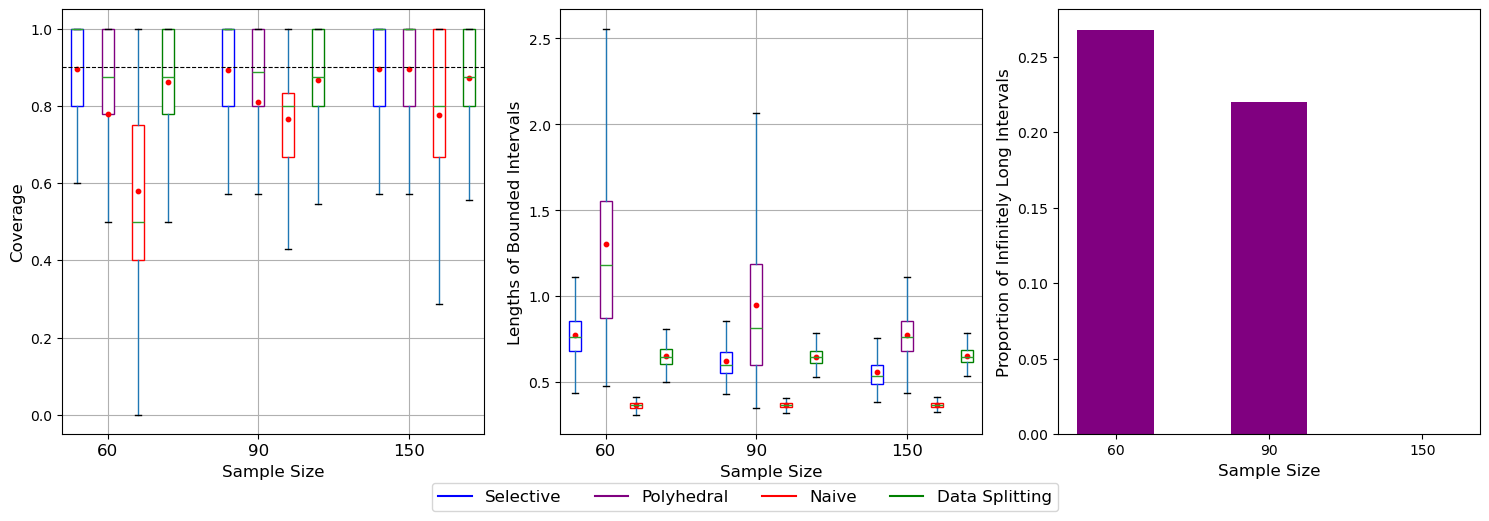

In [94]:
data=dfn 

# Splitting the data into two DataFrames: one for lengths and one for coverages
length_cols = [col for col in data.columns if "Length" in col]
coverage_cols = [col for col in data.columns if "Coverage" in col]
poly_cols = [col for col in data.columns if "Polyhedral Lengths" in col]

# Creating separate DataFrames for lengths and coverage
length_df = data[length_cols]
coverage_df = data[coverage_cols]

# Create figure with 3 subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
boxplot_width = 0.4

# 1st Plot: Coverage Boxplot
box_plot_coverage = coverage_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[0]
)

colors_group1 = ['blue', 'purple', 'red', 'green'] * 3
for box, color in zip(box_plot_coverage['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = coverage_df.mean()
ax[0].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[0].axhline(y=0.9, color='black', linestyle='--', linewidth=0.8)
ax[0].set_xticks([2, 7, 12])
ax[0].set_xticklabels(['60', '90', '150'], fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].set_xlabel('Sample Size', fontsize=12)


# 2nd Plot: Lengths Boxplot
length_df = length_df.replace([np.inf, -np.inf], np.nan)
box_plot_length = length_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[1]
)

for box, color in zip(box_plot_length['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = length_df.mean()
ax[1].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[1].set_xticks([2, 7, 12])
ax[1].set_xticklabels(['60', '90', '150'], fontsize=12)
ax[1].set_ylabel('Lengths of Bounded Intervals', fontsize=12)
ax[1].set_xlabel('Sample Size', fontsize=12)


# 3rd Plot: Proportion of Infinitely Long Intervals
proportions_inf = data[poly_cols].apply(lambda col: np.isinf(col).sum() / len(col))
proportions = list(proportions_inf.values)

x = np.arange(len(proportions))
categories = ['60', '90', '150']

bars = ax[2].bar(x, proportions, color='purple', width=0.5)
ax[2].set_xticks(x)
ax[2].set_xticklabels(categories)
ax[2].set_xlabel('Sample Size', fontsize=12)
ax[2].set_ylabel('Proportion of Infinitely Long Intervals', fontsize=12)

# --- Legend for the Entire Figure (Below the Plots) ---
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add the legend at the bottom center of the figure
fig.legend(
    handles=[legend_set1, legend_set2, legend_set3, legend_set4], 
    loc='lower center', bbox_to_anchor=(0.5, -0.05),  # Centered below the plots
    ncol=4, fontsize=12  # Arrange legend entries in a row
)


# Add a common X-axis label
# fig.supxlabel('Signal Strength', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

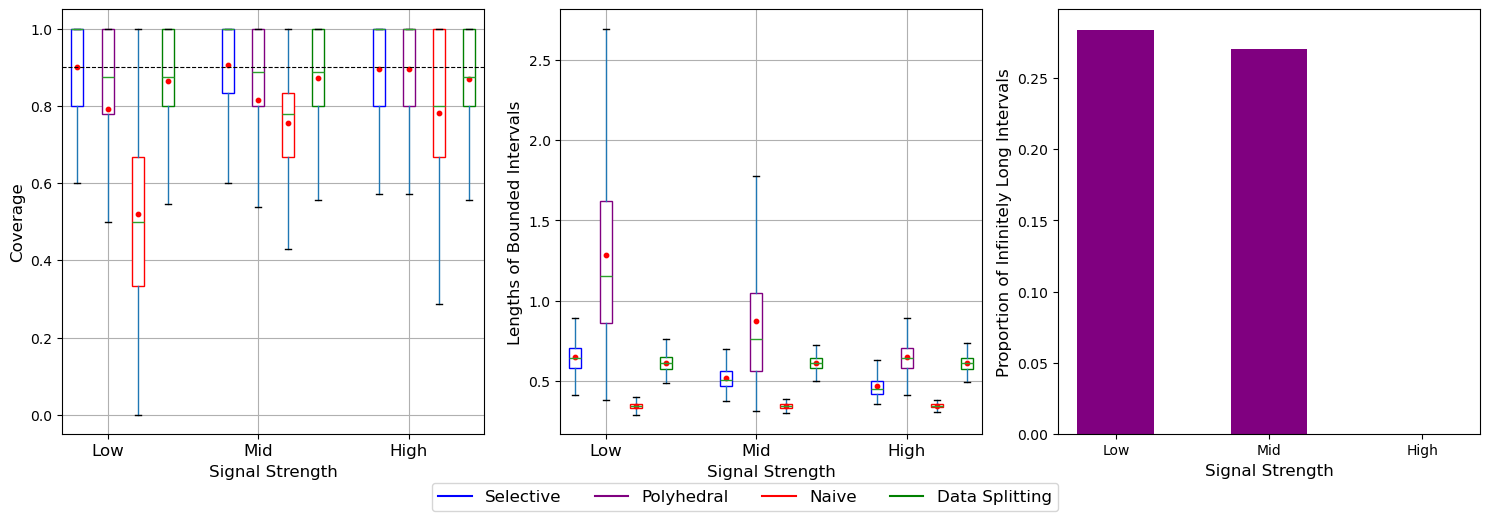

In [95]:
data=dfsn 

# Splitting the data into two DataFrames: one for lengths and one for coverages
length_cols = [col for col in data.columns if "Length" in col]
coverage_cols = [col for col in data.columns if "Coverage" in col]
poly_cols = [col for col in data.columns if "Polyhedral Lengths" in col]

# Creating separate DataFrames for lengths and coverage
length_df = data[length_cols]
coverage_df = data[coverage_cols]

# Create figure with 3 subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
boxplot_width = 0.4

# 1st Plot: Coverage Boxplot
box_plot_coverage = coverage_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[0]
)

colors_group1 = ['blue', 'purple', 'red', 'green'] * 3
for box, color in zip(box_plot_coverage['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = coverage_df.mean()
ax[0].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[0].axhline(y=0.9, color='black', linestyle='--', linewidth=0.8)
ax[0].set_xticks([2, 7, 12])
ax[0].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].set_xlabel('Signal Strength', fontsize=12)


# 2nd Plot: Lengths Boxplot
length_df = length_df.replace([np.inf, -np.inf], np.nan)
box_plot_length = length_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[1]
)

for box, color in zip(box_plot_length['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = length_df.mean()
ax[1].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[1].set_xticks([2, 7, 12])
ax[1].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)
ax[1].set_ylabel('Lengths of Bounded Intervals', fontsize=12)
ax[1].set_xlabel('Signal Strength', fontsize=12)


# 3rd Plot: Proportion of Infinitely Long Intervals
proportions_inf = data[poly_cols].apply(lambda col: np.isinf(col).sum() / len(col))
proportions = list(proportions_inf.values)

x = np.arange(len(proportions))
categories = ['Low', 'Mid', 'High']

bars = ax[2].bar(x, proportions, color='purple', width=0.5)
ax[2].set_xticks(x)
ax[2].set_xticklabels(categories)
ax[2].set_xlabel('Signal Strength', fontsize=12)
ax[2].set_ylabel('Proportion of Infinitely Long Intervals', fontsize=12)

# --- Legend for the Entire Figure (Below the Plots) ---
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add the legend at the bottom center of the figure
fig.legend(
    handles=[legend_set1, legend_set2, legend_set3, legend_set4], 
    loc='lower center', bbox_to_anchor=(0.5, -0.05),  # Centered below the plots
    ncol=4, fontsize=12  # Arrange legend entries in a row
)


# Add a common X-axis label
# fig.supxlabel('Signal Strength', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

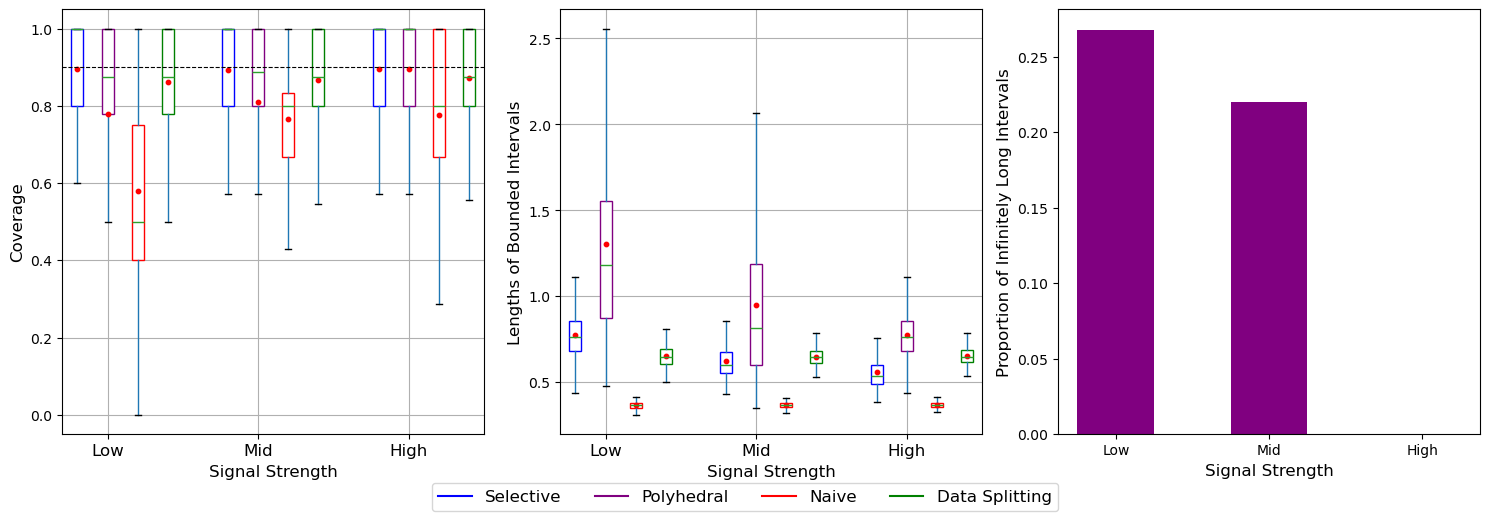

In [91]:
data=dfsl 

# Splitting the data into two DataFrames: one for lengths and one for coverages
length_cols = [col for col in data.columns if "Length" in col]
coverage_cols = [col for col in data.columns if "Coverage" in col]
poly_cols = [col for col in data.columns if "Polyhedral Lengths" in col]

# Creating separate DataFrames for lengths and coverage
length_df = data[length_cols]
coverage_df = data[coverage_cols]

# Create figure with 3 subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
boxplot_width = 0.4

# 1st Plot: Coverage Boxplot
box_plot_coverage = coverage_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[0]
)

colors_group1 = ['blue', 'purple', 'red', 'green'] * 3
for box, color in zip(box_plot_coverage['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = coverage_df.mean()
ax[0].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[0].axhline(y=0.9, color='black', linestyle='--', linewidth=0.8)
ax[0].set_xticks([2, 7, 12])
ax[0].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].set_xlabel('Signal Strength', fontsize=12)


# 2nd Plot: Lengths Boxplot
length_df = length_df.replace([np.inf, -np.inf], np.nan)
box_plot_length = length_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[1]
)

for box, color in zip(box_plot_length['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = length_df.mean()
ax[1].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[1].set_xticks([2, 7, 12])
ax[1].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)
ax[1].set_ylabel('Lengths of Bounded Intervals', fontsize=12)
ax[1].set_xlabel('Signal Strength', fontsize=12)


# 3rd Plot: Proportion of Infinitely Long Intervals
proportions_inf = data[poly_cols].apply(lambda col: np.isinf(col).sum() / len(col))
proportions = list(proportions_inf.values)

x = np.arange(len(proportions))
categories = ['Low', 'Mid', 'High']

bars = ax[2].bar(x, proportions, color='purple', width=0.5)
ax[2].set_xticks(x)
ax[2].set_xticklabels(categories)
ax[2].set_xlabel('Signal Strength', fontsize=12)
ax[2].set_ylabel('Proportion of Infinitely Long Intervals', fontsize=12)

# --- Legend for the Entire Figure (Below the Plots) ---
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add the legend at the bottom center of the figure
fig.legend(
    handles=[legend_set1, legend_set2, legend_set3, legend_set4], 
    loc='lower center', bbox_to_anchor=(0.5, -0.05),  # Centered below the plots
    ncol=4, fontsize=12  # Arrange legend entries in a row
)


# Add a common X-axis label
# fig.supxlabel('Signal Strength', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

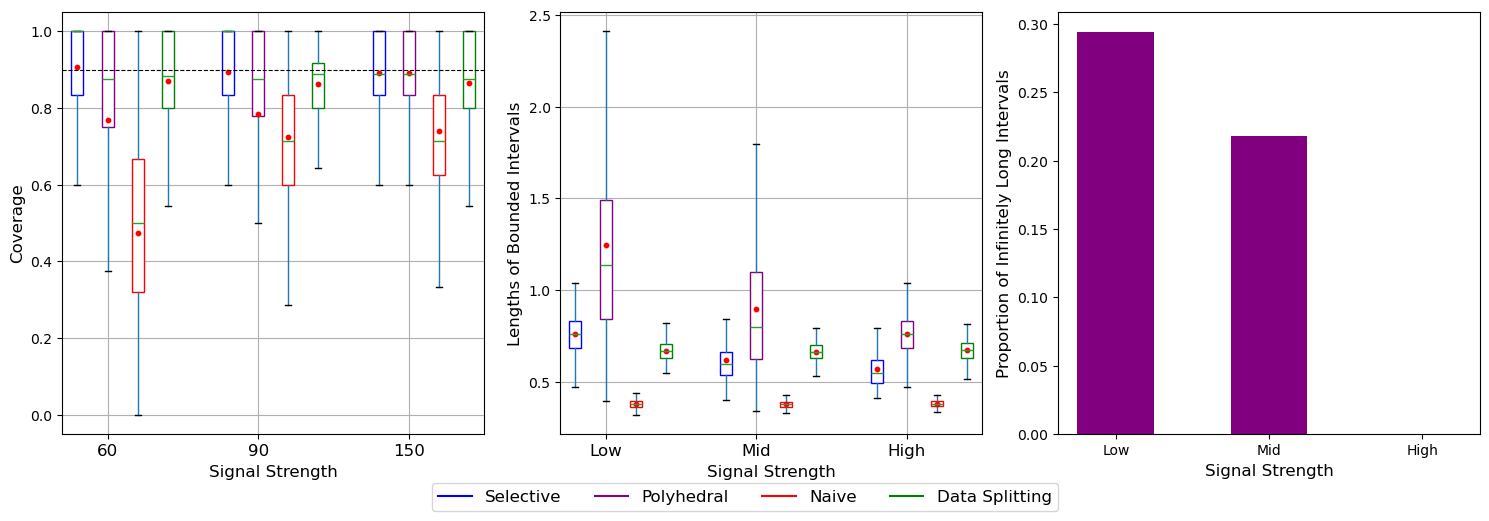

In [96]:
data=dfse

# Splitting the data into two DataFrames: one for lengths and one for coverages
length_cols = [col for col in data.columns if "Length" in col]
coverage_cols = [col for col in data.columns if "Coverage" in col]
poly_cols = [col for col in data.columns if "Polyhedral Lengths" in col]

# Creating separate DataFrames for lengths and coverage
length_df = data[length_cols]
coverage_df = data[coverage_cols]

# Create figure with 3 subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
boxplot_width = 0.4

# 1st Plot: Coverage Boxplot
box_plot_coverage = coverage_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[0]
)

colors_group1 = ['blue', 'purple', 'red', 'green'] * 3
for box, color in zip(box_plot_coverage['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = coverage_df.mean()
ax[0].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[0].axhline(y=0.9, color='black', linestyle='--', linewidth=0.8)
ax[0].set_xticks([2, 7, 12])
ax[0].set_xticklabels(['60', '90', '150'], fontsize=12)
ax[0].set_ylabel('Coverage', fontsize=12)
ax[0].set_xlabel('Signal Strength', fontsize=12)


# 2nd Plot: Lengths Boxplot
length_df = length_df.replace([np.inf, -np.inf], np.nan)
box_plot_length = length_df.boxplot(
    widths=boxplot_width, positions=[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], 
    sym='', patch_artist=True, return_type='dict', ax=ax[1]
)

for box, color in zip(box_plot_length['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = length_df.mean()
ax[1].scatter([1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14], means, color='red', marker='o', s=10, zorder=2)

ax[1].set_xticks([2, 7, 12])
ax[1].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)
ax[1].set_ylabel('Lengths of Bounded Intervals', fontsize=12)
ax[1].set_xlabel('Signal Strength', fontsize=12)


# 3rd Plot: Proportion of Infinitely Long Intervals
proportions_inf = data[poly_cols].apply(lambda col: np.isinf(col).sum() / len(col))
proportions = list(proportions_inf.values)

x = np.arange(len(proportions))
categories = ['Low', 'Mid', 'High']

bars = ax[2].bar(x, proportions, color='purple', width=0.5)
ax[2].set_xticks(x)
ax[2].set_xticklabels(categories)
ax[2].set_xlabel('Signal Strength', fontsize=12)
ax[2].set_ylabel('Proportion of Infinitely Long Intervals', fontsize=12)

# --- Legend for the Entire Figure (Below the Plots) ---
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add the legend at the bottom center of the figure
fig.legend(
    handles=[legend_set1, legend_set2, legend_set3, legend_set4], 
    loc='lower center', bbox_to_anchor=(0.5, -0.05),  # Centered below the plots
    ncol=4, fontsize=12  # Arrange legend entries in a row
)


# Add a common X-axis label
# fig.supxlabel('Signal Strength', fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

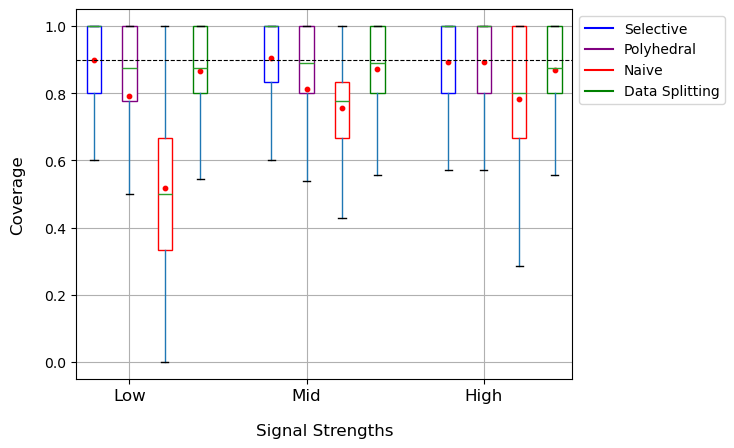

In [62]:
fig, ax = plt.subplots()
boxplot_width = 0.4

# Create boxplots with spacing
box_plot_coverage = coverage_df.boxplot(widths=boxplot_width, positions=[1,2,3,4,6,7, 8,9, 11, 12, 13, 14], sym='', patch_artist=True, return_type='dict')

colors_group1 = ['blue',  'purple', 'red', 'green']*3
for box,color in zip(box_plot_coverage['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = coverage_df.mean()

# Add red dots for mean values
plt.scatter([[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]], means, color='red', marker='o', s=10, zorder=2)

# Making 0.9 line
plt.axhline(y=0.9, color='black', linestyle='--', linewidth=0.8)

#Making X labels
ax.set_xticks([2, 7, 12])
ax.set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)

#Making legends
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add custom legend outside the plot area
ax.legend(handles=[legend_set1, legend_set2, legend_set3, legend_set4], loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Signal Strengths', labelpad=14, fontsize=12)
plt.ylabel('Coverage', labelpad=14, fontsize=12)
# plt.title('Coverage') #

plt.show()

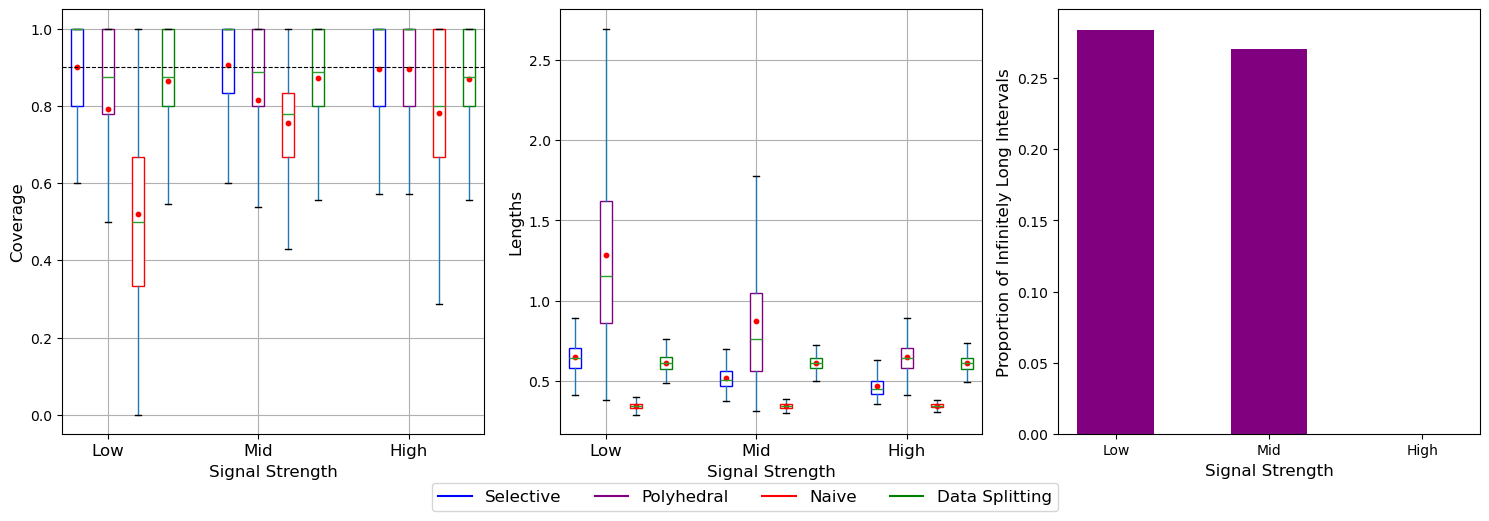

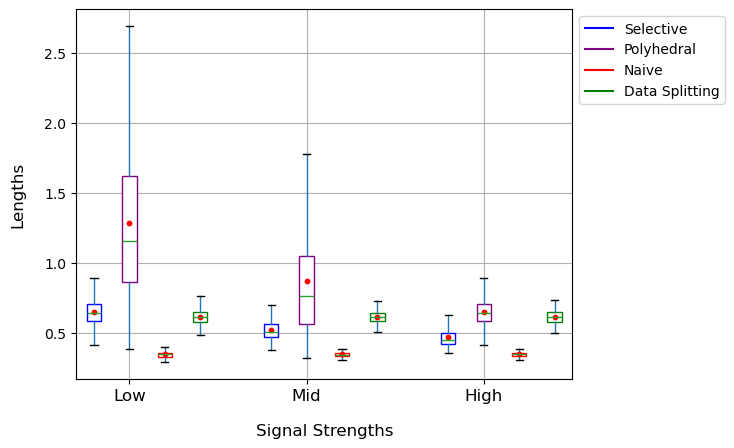

In [64]:
length_df = length_df.replace([np.inf, -np.inf], np.nan)

fig, ax= plt.subplots()

# Create boxplots with spacing
box_plot_length = length_df.boxplot(widths=boxplot_width, positions=[1,2,3,4,6,7, 8,9, 11, 12, 13, 14], sym='', patch_artist=True, return_type='dict')

#ax = df.boxplot(column=list(df.columns),widths=boxplot_width, positions=[1,2,3,4,6,7, 8,9, 11, 12, 13, 14] , patch_artist=True, sym='', boxprops=dict(facecolor='white'))

colors_group1 = ['blue', 'purple', 'red', 'green']*3
for box,color in zip(box_plot_length['boxes'], colors_group1):
    box.set_facecolor('white')
    box.set_edgecolor(color)

means = length_df.mean()

# Add red dots for mean values
plt.scatter([[1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]], means, color='red', marker='o', s=10, zorder=2)


#Making X labels
ax[1].set_xticks([2, 7, 12])
ax[1].set_xticklabels(['Low', 'Mid', 'High'], fontsize=12)

#Making legends
legend_set1 = mlines.Line2D([], [], color=colors_group1[0], label='Selective')
legend_set2 = mlines.Line2D([], [], color=colors_group1[1], label='Polyhedral')
legend_set3 = mlines.Line2D([], [], color=colors_group1[2], label='Naive')
legend_set4 = mlines.Line2D([], [], color=colors_group1[3], label='Data Splitting')

# Add custom legend outside the plot area
ax.legend(handles=[legend_set1, legend_set2, legend_set3, legend_set4], loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Signal Strengths', labelpad=14, fontsize=12)
plt.ylabel('Lengths', labelpad=14, fontsize=12)
# plt.title('Length')
plt.show()

In [68]:
# Calculate the proportion of 'inf' values for each column
proportions_inf = data[poly_cols].apply(lambda col: np.isinf(col).sum() / len(col))

# Convert to numpy array
proportions_array = proportions_inf.values
list(proportions_inf.values)
# proportions_array

[0.284, 0.27, 0.0]

[Text(0, 0, 'Low'), Text(1, 0, 'Mid'), Text(2, 0, 'High')]

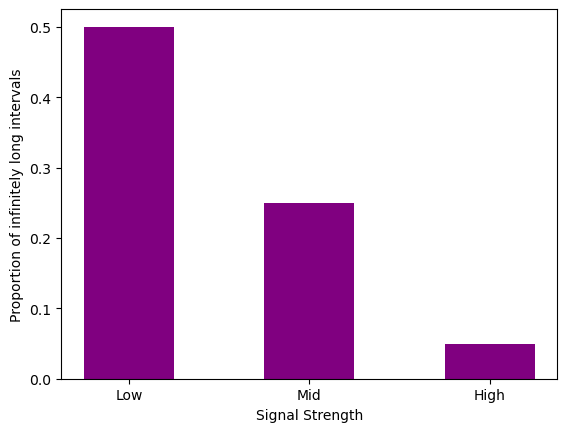

In [48]:
# Example data: replace this with your actual proportions
categories = ['Low', 'Mid', 'High']
proportions = [0.5, 0.25, 0.05]  # Example proportions

x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots()

# Plotting a simple bar plot
bars = ax.bar(x, proportions, color='purple', width=0.5)

# Adding some labels and title
ax.set_xlabel('Signal Strength')
ax.set_ylabel('Proportion of infinitely long intervals')
ax.set_xticks(x)
ax.set_xticklabels(categories)

In [13]:
nsim =  500
bcoverage1_0 = []
bcoverage2_0 = []
bcoverage2f_0 = []
bcoverage3_0 = []
blength1_0 = []
blength2_0 = []
blength3_0 = []

for i in tqdm(range(nsim)):
    output1 = compwl_inf(N=900, beta_11=20)
    
    if output1 is not None:
        coverage1_0, coverage2_0, coverage3_0, length1_0, length2_0, length3_0 = output1
        bcoverage1_0.append(np.mean(coverage1_0))
        bcoverage2_0.append(np.mean(coverage2_0))
        # bcoverage2f_0.append(np.mean(coverage2f_0))
        bcoverage3_0.append(np.mean(coverage3_0))
        blength1_0.append(np.mean(length1_0))
        blength2_0.append(np.mean(length2_0))
        blength3_0.append(np.mean(length3_0))
    

100%|██████████| 500/500 [35:37<00:00,  4.27s/it]   


In [15]:
print("SI Coverage", np.mean(bcoverage1_0))
print("Polyhedral Coverage", np.mean(bcoverage2_0))
# print("Polyhedral Finite Intervals Coverage", np.mean(bcoverage2f_0))
print("Splitting Coverage", np.mean(bcoverage3_0))
print("SI Length", np.mean(blength1_0))
print("Polyhedral Length", np.mean(blength2_0))
print("Splitting Length", np.mean(blength3_0))
blength2_0 = np.array(blength2_0)
finite_lengths_0 = blength2_0[np.isfinite(blength2_0)]
print("Polyhedral Finite Length", np.mean(finite_lengths_0))
print("Proportion of finite intervals",len(finite_lengths_0)/500)

SI Coverage 0.8842310578310578
Polyhedral Coverage 0.8317951048951049
Splitting Coverage 0.8911147963147964
SI Length 1.4549222196930025
Polyhedral Length inf
Splitting Length 1.7413400997080621
Polyhedral Finite Length 2.082366470702083
Proportion of finite intervals 0.826


In [268]:
bcoverage2f_0 = np.array(bcoverage2f_0)
np.mean( bcoverage2f_0[~np.isnan(bcoverage2f_0)])

0.952047439396837

In [197]:
Data_compoly0 = pd.DataFrame({"Selective Coverage (0.6)": bcoverage1_0, "Polyhedral Coverage (0.6)": bcoverage2_0, " Split Coverage (0.6)": bcoverage3_0, "Selective CI Lengths (0.6)": blength1_0, "Polyhedral Lengths (0.6)": blength2_0, "Data Splitting CI Lengths (0.6)": blength3_0})
Data_compoly0.to_csv('Data_comply0.csv')

In [92]:
Data_compoly1.to_csv('Data_comply1.csv')
Data_compoly2.to_csv('Data_comply2.csv')
Data_compoly3.to_csv('Data_comply3.csv')
Data_compoly4.to_csv('Data_comply4.csv')

In [123]:
coverage_columns = ['Selective Coverage (0.6)', 'Polyhedral Coverage (0.6)', ' Split Coverage (0.6)']
print(Data_compoly0[coverage_columns].mean())

Selective Coverage (0.6)     0.924098
Polyhedral Coverage (0.6)    0.903833
 Split Coverage (0.6)        0.911483
dtype: float64


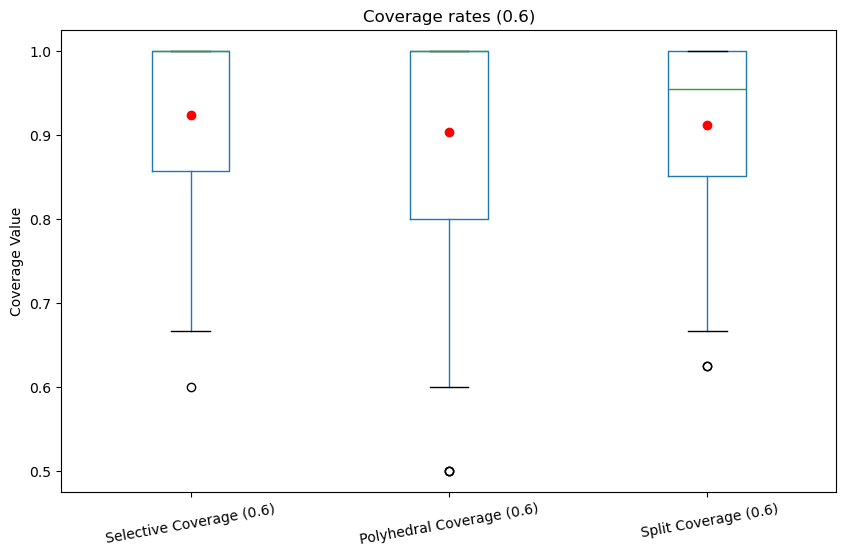

In [124]:
coverage_columns = ['Selective Coverage (0.6)', 'Polyhedral Coverage (0.6)', ' Split Coverage (0.6)']

# Plotting box plots with means as red dots
plt.figure(figsize=(10, 6))
boxplot = Data_compoly0[coverage_columns].boxplot(
    return_type='dict'
)
# Plotting the means as red dots
means = Data_compoly0[coverage_columns].mean()
for i, mean in enumerate(means):
    plt.plot(i + 1, mean, 'ro')

plt.title('Coverage rates (0.6)')
plt.ylabel('Coverage Value')
plt.xticks(rotation=10)
plt.grid(False)
# plt.show()
plt.savefig('coverage_0.png')

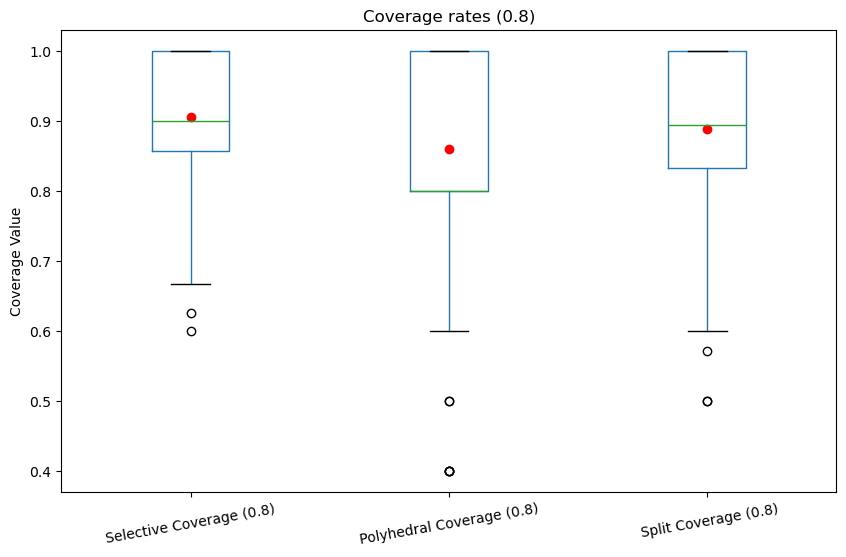

In [116]:
coverage_columns = ['Selective Coverage (0.8)', 'Polyhedral Coverage (0.8)', ' Split Coverage (0.8)']

# Plotting box plots with means as red dots
plt.figure(figsize=(10, 6))
boxplot = Data_compoly1[coverage_columns].boxplot(
    return_type='dict'
)
# Plotting the means as red dots
means = Data_compoly1[coverage_columns].mean()
for i, mean in enumerate(means):
    plt.plot(i + 1, mean, 'ro')

plt.title('Coverage rates (0.8)')
plt.ylabel('Coverage Value')
plt.xticks(rotation=10)
plt.grid(False)
# plt.show()
plt.savefig('coverage_1.png')

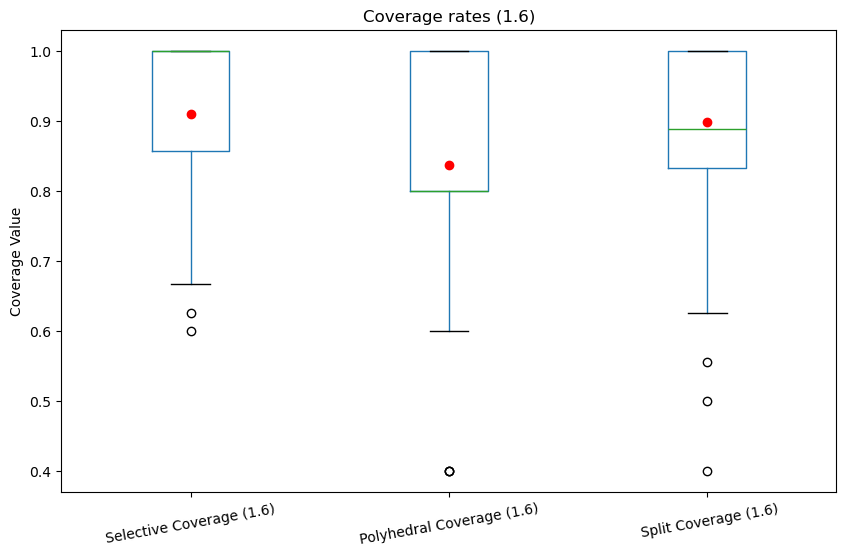

<Figure size 640x480 with 0 Axes>

In [110]:
coverage_columns = ['Selective Coverage (1.6)', 'Polyhedral Coverage (1.6)', ' Split Coverage (1.6)']

# Plotting box plots with means as red dots
plt.figure(figsize=(10, 6))
boxplot = Data_compoly2[coverage_columns].boxplot(
    return_type='dict'
)
# Plotting the means as red dots
means = Data_compoly2[coverage_columns].mean()
for i, mean in enumerate(means):
    plt.plot(i + 1, mean, 'ro')

plt.title('Coverage rates (1.6)')
plt.ylabel('Coverage Value')
plt.xticks(rotation=10)
plt.grid(False)
plt.show()
plt.savefig('coverage_2.png')

In [ ]:
# Polyhedral Method Function
def lee_inf(N=300,
            beta_11=4.4):
    
    X, Y, beta, A = MRT_instance(N=N, beta_11=beta_11)[:4]

    n, p = X.shape
    sigma_ = np.std(Y)

    if n > (2 * p):
        dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
    else:
        dispersion = sigma_ ** 2

    eps = np.random.standard_normal((n, 2000)) * Y.std()
    lambda_value = 1.1 * np.median(np.abs(X.T.dot(eps)).max(1))
 
    # lambda_value = 1.1

    # Fit the standard Lasso without an intercept
    slf = linear_model.Lasso(alpha=lambda_value/n, fit_intercept=False)
    slf.fit(X, Y)
    nonzero2 = slf.coef_ != 0
    beta_target2 = np.linalg.pinv(X[:, nonzero2]).dot(X.dot(beta))
            
    if nonzero2.sum() > 0:

        # Apply Polyhedral method from selectiveInference package in R 
        results = selectiveInference.fixedLassoInf(X, Y, slf.coef_, lam=lambda_value, sigma=1)
        pvals = np.array(results.rx2('pval'))
        pci = np.array(results.rx2('ci'))
        plci = pci[:, 0]
        puci = pci[:, 1]
        coverage2 = (plci < beta_target2) * (puci > beta_target2)
        length2 = puci - plci
    
    return coverage2, length2

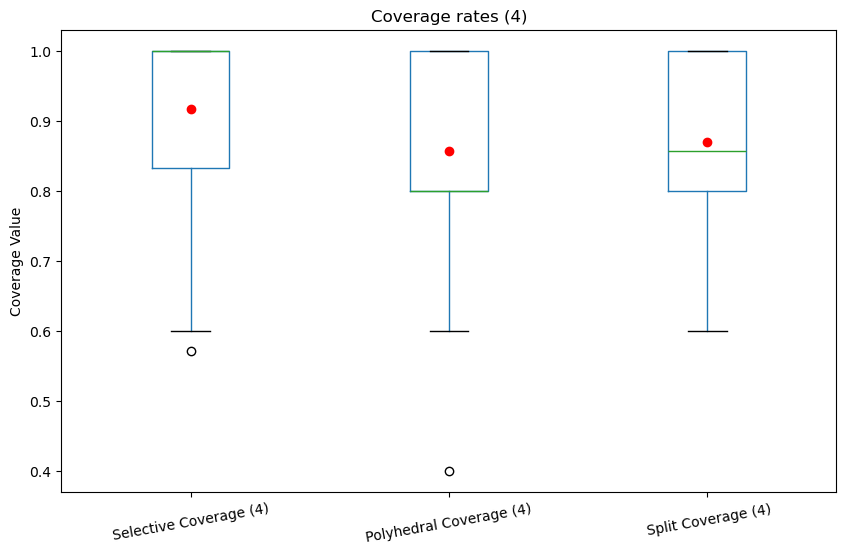

<Figure size 640x480 with 0 Axes>

In [109]:
coverage_columns = ['Selective Coverage (4)', 'Polyhedral Coverage (4)', ' Split Coverage (4)']

# Plotting box plots with means as red dots
plt.figure(figsize=(10, 6))
boxplot = Data_compoly3[coverage_columns].boxplot(
    return_type='dict'
)
# Plotting the means as red dots
means = Data_compoly3[coverage_columns].mean()
for i, mean in enumerate(means):
    plt.plot(i + 1, mean, 'ro')

plt.title('Coverage rates (4)')
plt.ylabel('Coverage Value')
plt.xticks(rotation=10)
plt.grid(False)
plt.show()
plt.savefig('coverage_3.png')

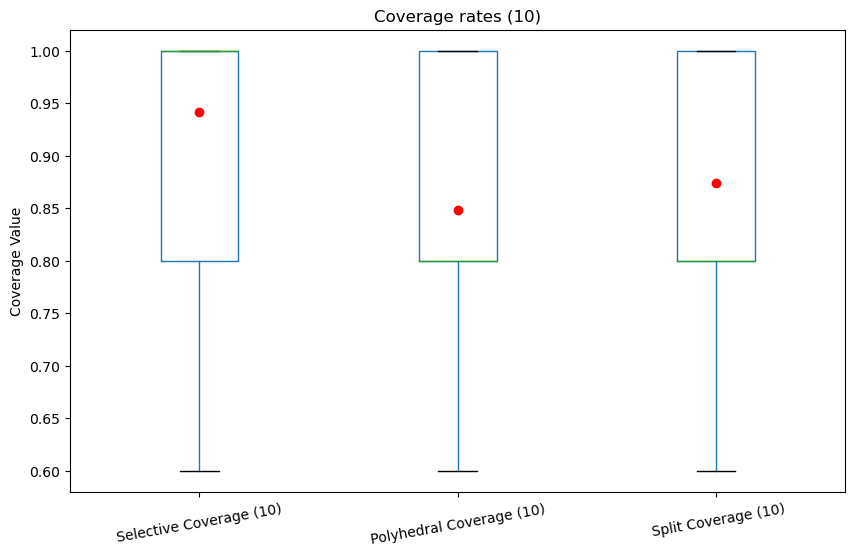

<Figure size 640x480 with 0 Axes>

In [113]:
coverage_columns = ['Selective Coverage (10)', 'Polyhedral Coverage (10)', ' Split Coverage (10)']

# Plotting box plots with means as red dots
plt.figure(figsize=(10, 6))
boxplot = Data_compoly4[coverage_columns].boxplot(
    return_type='dict'
)
# Plotting the means as red dots
means = Data_compoly4[coverage_columns].mean()
for i, mean in enumerate(means):
    plt.plot(i + 1, mean, 'ro')

plt.title('Coverage rates (10)')
plt.ylabel('Coverage Value')
plt.xticks(rotation=10)
plt.grid(False)
plt.show()
plt.savefig('coverage_4.png')

In [ ]:
nsim = 50
bcoverage1 = []
bcoverage2 = []
blength1 = []
blength2 = []

for i in tqdm(range(nsim)):
    coverage2, length2 = lee_inf(N=600, beta_11=7.8)
    bcoverage2.append(np.mean(coverage2))
    blength2.append(np.mean(length2))

In [ ]:
print(np.mean(bcoverage2))
print(np.mean(blength2))
blength2 = np.array(blength2)
finite_lengths = blength2[np.isfinite(blength2)]
print(np.mean(finite_lengths))

## DATA APP

In [17]:
AW_df = pd.read_csv('~/Documents/git/SI-MRT/realdata/AW_df.csv')
variables = [
    'ParticipantIdentifier',
    'Value_tran',
    'Notification_c',
    'TimeEnrolled_days',
    'Phases',
    'Value_30min_before',
    'NotificationType',
    'Baseline_steps',
    'IsWeekend',
    'IsIndoor',
    'IsLossFramed',
    'IsSnow',
    'IsActivity',
    'Value_30min_before_tran',
    'AgeEnrollment_years',
    'Gender',
    'Race',
    'ExerciseTimeAgg_min',
    'WalkDistanceAgg_m',
    'StepsAgg_priorweek',
    'Value_tran_sd_week',
    'Value_tran_sd_priorweek',
    'Distance_m_0'
]
 
#data = AW_df[variables].dropna()
data = AW_df[variables].replace([np.inf, -np.inf], np.nan).dropna()

# Apply one-hot encoding to the non-numeric columns in the dataset
non_numeric_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_cols, drop_first=True)

# Print the number of unique IDs and the count of rows per ID
# print(f"Number of unique IDs: {data['ParticipantIdentifier'].nunique()}")
# print("\nNumber of rows for each ID:")
# print(data['ParticipantIdentifier'].value_counts())
# data['ParticipantIdentifier'].unique()


# One-hot encode 'Phases'
data['Phase1'] = data['TimeEnrolled_days'] * (data['Phases'] == 1).astype(int)
data['Phase2'] = data['TimeEnrolled_days'] * (data['Phases'] == 2).astype(int)
data['Phase3'] = data['TimeEnrolled_days'] * (data['Phases'] == 3).astype(int)


# Remove original Phase columns
data = data.drop(columns=['Phases'])
# data = data.drop(columns=['Phase1', 'Phase2', 'Phase3'])
data = data.drop(columns=['TimeEnrolled_days'])

In [18]:
data

,ParticipantIdentifier,Value_tran,Notification_c,Value_30min_before,Baseline_steps,IsWeekend,IsIndoor,IsLossFramed,IsSnow,IsActivity,...,NotificationType_evening,NotificationType_lunch,NotificationType_morning,Gender_M,Race_Caucasian,Race_Other,Race_Unknown,Phase1,Phase2,Phase3
8,3,5.661223,-0.225066,223.0,4037.571429,0,0,0,0,0,...,False,False,True,False,True,False,False,0,50,0
9,3,5.596568,-0.225066,8.0,4037.571429,0,0,0,0,0,...,False,True,False,False,True,False,False,0,50,0
10,3,6.017376,-0.225066,438.0,4037.571429,0,0,0,0,0,...,False,False,False,False,True,False,False,0,50,0
11,3,5.671604,-0.225066,116.0,4037.571429,0,0,0,0,0,...,True,False,False,False,True,False,False,0,50,0
12,3,5.495117,0.774934,169.0,4037.571429,1,1,0,0,1,...,False,True,False,False,True,False,False,0,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34066,925,5.618588,-0.225066,737.0,8030.714286,0,0,0,0,0,...,False,True,False,False,False,False,False,0,0,183
34068,925,6.772508,-0.225066,533.0,8030.714286,0,0,0,0,0,...,True,False,False,False,False,False,False,0,0,183
34069,925,7.065186,-0.225066,77.0,8030.714286,0,0,0,0,0,...,False,False,True,False,False,False,False,0,0,184
34070,925,4.119037,-0.225066,194.0,8030.714286,0,0,0,0,0,...,False,True,False,False,False,False,False,0,0,184


In [19]:
np.random.seed(42019)

# Split data into estimation and rest set based on unique ParticipantIdentifier
unique_ids = data['ParticipantIdentifier'].unique()
est_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * 1/3), replace=False)
est_set = data[data['ParticipantIdentifier'].isin(est_ids)]
rest_set = data[~data['ParticipantIdentifier'].isin(est_ids)]

# Columns to exclude
columns_to_remove = ['ParticipantIdentifier', 'Value_tran', 'Notification_c']

# Define covariates for the model
covariates  = [col for col in data.columns if col not in columns_to_remove]

# Linear regression model for estimation set
X1 = est_set[covariates]
y1 = est_set['Value_tran']

alphahat = np.array(sm.OLS(y1, X1.astype(float)).fit().params)

Xp = rest_set[covariates]
Y = rest_set['Value_tran'] - np.dot(Xp,alphahat)
# X.loc[:, 'intercept'] = 1 

centered_treatment = rest_set['Notification_c']
Xp = Xp.multiply(centered_treatment, axis="index")

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# Xp = pd.DataFrame(scaler.fit_transform(Xp), columns=Xp.columns, index=Xp.index)

X=Xp.to_numpy(dtype='float64')
Y=Y.to_numpy(dtype='float64').reshape(-1)
n, p = X.shape
print(p)
scaling = X.std(0) * np.sqrt(n)
X /= np.sqrt(n)
sigma_ = np.std(Y)

names=Xp.columns

df = pd.DataFrame({
    'id': rest_set['ParticipantIdentifier']
}).join(Xp)

df['Y'] = Y

25


In [20]:
if n > (2 * p):
    dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
else:
    dispersion = sigma_ ** 2
    
eps = np.random.standard_normal((n, 2000)) * Y.std()
lambda_value = 21 * np.median(np.abs(X.T.dot(eps)).max(1))
# print(lambda_value)

# Fit the standard Lasso without an intercept
slf = linear_model.Lasso(alpha=lambda_value/n, fit_intercept=False, max_iter=10000, tol=1e-10)

slf.fit(X, Y)
# print(slf.coef_)
nonzero1 = slf.coef_ != 0
print("size of selected set ", nonzero1.sum())
print("selected moderators ", names[nonzero1])

#means and sds of selected columns
print(np.mean(X[:,nonzero1], axis=0))
print(np.std(X[:,nonzero1], axis=0))

# Apply Polyhedral method from selectiveInference package in R 
results = selectiveInference.fixedLassoInf(X, Y, slf.coef_, lam=lambda_value, sigma=np.sqrt(dispersion))
pvals = np.array(results.rx2('pval'))
intervals1 = np.array(results.rx2('ci'))

plci = intervals1[:, 0]
puci = intervals1[:, 1]
length1 = puci - plci
print("Polyhedral lengths", length1)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[0.02668134 0.27920133 0.22944609 0.19177054]
[ 1.92065476 30.7632434  25.22436199 28.09681954]


NameError: name 'selectiveInference' is not defined

In [21]:
W = 25 * np.median(np.abs(X.T.dot(eps)).max(1))

const = lasso.gaussian
randomizer_scale = 1.
conv = const(X,
             Y,
             W,
             ridge_term=0.,
             randomizer_scale=randomizer_scale * np.sqrt(dispersion))

signs = conv.fit()
nonzero2 = signs != 0
print("size of selected set ", nonzero2.sum())
print("selected moderators ", names[nonzero2])

#means and sds of selected columns
# print(np.mean(X[:,nonzero2], axis=0))
# print(np.std(X[:,nonzero2], axis=0))
if nonzero2.sum() > 0:
    
    conv.setup_inference(dispersion=dispersion)

    target_spec = selected_targets_WCLS(conv.loglike,
                                        df,
                                        conv.observed_soln,
                                        K = conv.K,
                                        dispersion= dispersion)

    result_exact = conv.inference(target_spec)

    intervals2 = np.asarray(result_exact[['lower_confidence', 'upper_confidence']])
    lci = intervals2[:, 0]
    uci = intervals2[:, 1]
    length2 = uci - lci

print(intervals2)
print("SI lengths",length2)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[[ 1.21081601e-03  1.58515218e-02]
 [ 4.90434759e-06  4.02274126e-03]
 [-8.72355017e-04  2.06242785e-03]
 [-5.68822310e-03 -7.10307729e-04]]
SI lengths [0.01464071 0.00401784 0.00293478 0.00497792]


In [259]:
# Rescaling intervals
means1=np.mean(X[:,nonzero2], axis=0).reshape(-1, 1)
sds1= np.std(X[:,nonzero2], axis=0).reshape(-1, 1)
rescaled_intervals2 = (intervals2 - means1)/sds1

In [25]:
#Data Splitting
unique_ids = df['id'].unique()
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42019).tolist()

# Split the IDs into train and test sets
test_prop = 0.3
train_size = int((1 - test_prop) * len(shuffled_ids))
train_ids = shuffled_ids[:train_size]
test_ids = shuffled_ids[train_size:]

# Split the dataframe based on these IDs
A_train = df[df['id'].isin(train_ids)]
A_test = df[df['id'].isin(test_ids)]
X_train = np.array(A_train.iloc[:, 1:-1])
Y_train = np.array(A_train.iloc[:, -1])


n_train = X_train.shape[0]
eps1 = np.random.standard_normal((n_train, 2000)) * Y_train.std()
W_train = 20 *  n_train/n * np.median(np.abs(X_train.T.dot(eps1)).max(1))

conv2 = const(X_train,
          Y_train,
          W_train,
          ridge_term=0.,
          randomizer_scale=1)

signs3 = conv2.fit(perturb=np.zeros(p))
nonzero3 = signs3 != 0
print("size of selected set ", nonzero2.sum())
print("selected moderators ", names[nonzero2])

Xf1 = np.array(A_test.iloc[:, 1:-1])
#means and sds of selected columns
print(np.mean(Xf1[:,nonzero3], axis=0))
print(np.std(Xf1[:,nonzero3], axis=0))

Xf1 = Xf1[:, nonzero2]
yf1 = A_test['Y']
groups = A_test['id']

# fit the GEE model
model2 = sm.GEE(yf1, Xf1, groups=groups, family=sm.families.Gaussian(), cov_struct=sm.cov_struct.Independence())
result_split = model2.fit(cov_type='robust')

intervals3 = np.array(result_split.conf_int(alpha=0.1)) *  np.sqrt(n)

lci = intervals3[:, 0]
uci = intervals3[:, 1]
length3 = uci - lci

print(intervals3)
print("Split lengths",length3)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[-0.17683621 33.08353627 35.42415084 16.59236738  3.07026369  0.0870154 ]
[ 216.19221454 3658.43576227 3344.07912059 3417.79973736  225.74049575
   24.78802149]
[[-0.01643074  0.01608918]
 [-0.00176959  0.00325589]
 [-0.00223577  0.00227603]
 [-0.00428882  0.00242082]]
Split lengths [0.03251992 0.00502548 0.0045118  0.00670963]


In [265]:
intervals

0.46662385902481696

In [27]:
# print("Poly avg length",np.mean(length1))
print("SI avg length", np.mean(length2))
print("Split avg length", np.mean(length3))
print("SI/Split avg length", np.mean(length2)/np.mean(length3))
snames=names[nonzero2]

SI avg length 0.006642810229533056
Split avg length 0.012191708907943497
SI/Split avg length 0.5448629293638186


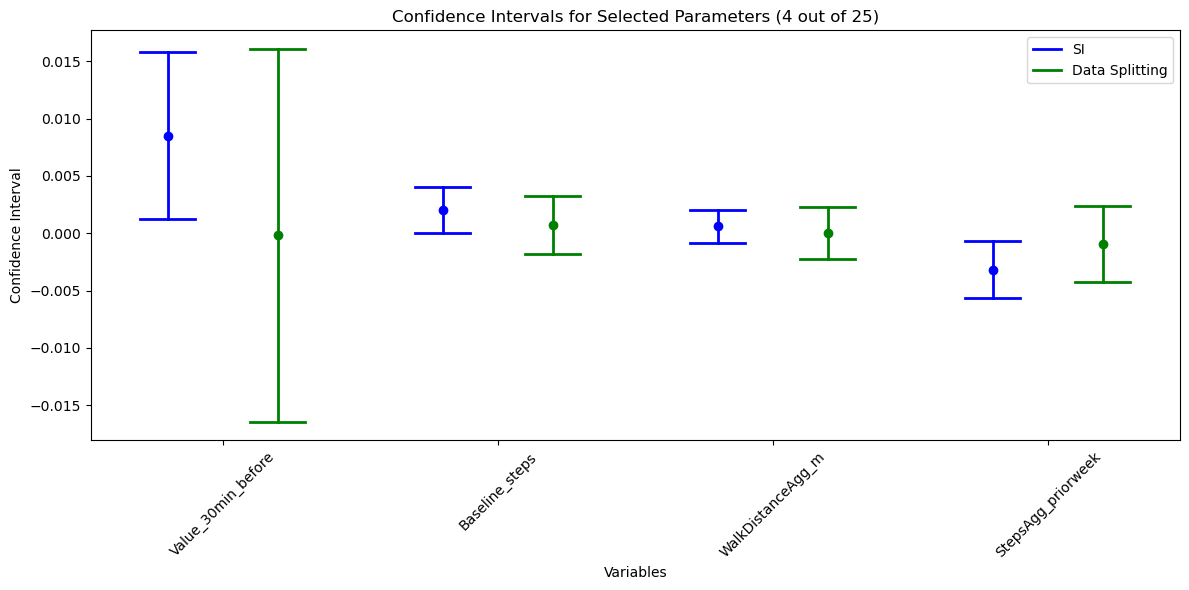

In [32]:
# Calculate midpoints for both sets of intervals
midpoints2 = (intervals2[:, 0] + intervals2[:, 1]) / 2
midpoints3 = (intervals3[:, 0] + intervals3[:, 1]) / 2

# Plot settings
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4  # Width for each set of CIs
x_positions = np.arange(len(snames))  # X positions for variables

# Plot each CI for method 1
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals2, midpoints2)):
    ax.plot([x_positions[i] - bar_width / 2, x_positions[i] - bar_width / 2], ci, color='blue', linewidth=2, label="SI" if i == 0 else "")
    ax.plot(x_positions[i] - bar_width / 2, midpoint, 'o', color='blue')
    ax.plot([x_positions[i] - bar_width / 2 - 0.1, x_positions[i] - bar_width / 2 + 0.1], [ci[0], ci[0]], color='blue', linewidth=2)
    ax.plot([x_positions[i] - bar_width / 2 - 0.1, x_positions[i] - bar_width / 2 + 0.1], [ci[1], ci[1]], color='blue', linewidth=2)

# Plot each CI for method 2
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals3, midpoints3)):
    ax.plot([x_positions[i] + bar_width / 2, x_positions[i] + bar_width / 2], ci, color='green', linewidth=2, label="Data Splitting" if i == 0 else "")
    ax.plot(x_positions[i] + bar_width / 2, midpoint, 'o', color='green')
    ax.plot([x_positions[i] + bar_width / 2 - 0.1, x_positions[i] + bar_width / 2 + 0.1], [ci[0], ci[0]], color='green', linewidth=2)
    ax.plot([x_positions[i] + bar_width / 2 - 0.1, x_positions[i] + bar_width / 2 + 0.1], [ci[1], ci[1]], color='green', linewidth=2)

# Set x-ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(snames)
ax.set_ylabel("Confidence Interval")
ax.set_xlabel("Variables")
ax.set_title("Confidence Intervals for Selected Parameters (4 out of 25)")

# Add legend in the top-right corner
ax.legend(loc='upper right')
plt.xticks(rotation=45)  # Rotate variable names if they overlap
plt.tight_layout()
plt.show()

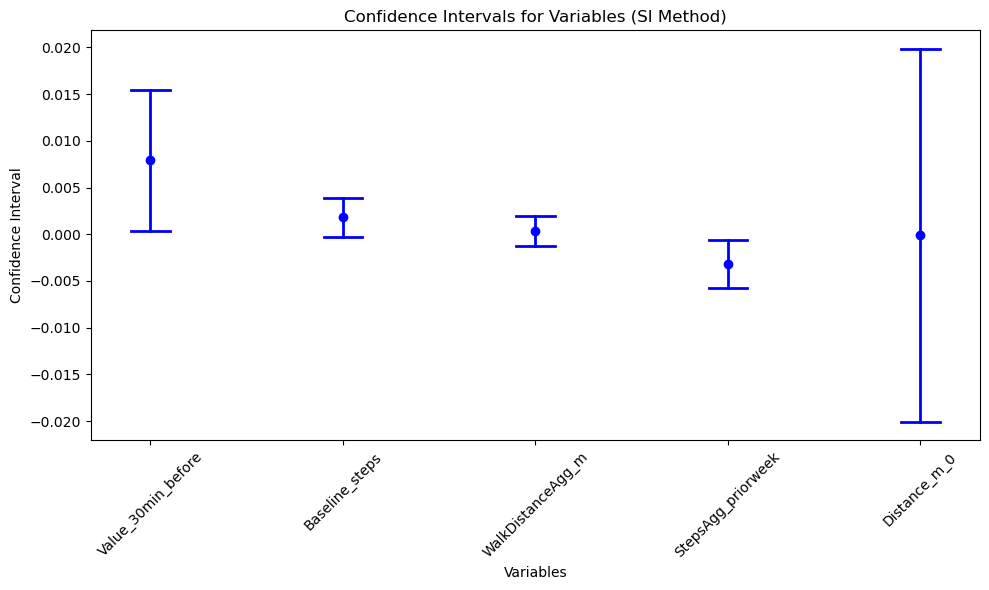

In [270]:
# Choose the method data
intervals = intervals2 
# intervals = rescaled_intervals2
color = 'blue'  

# Calculate midpoints for the intervals
midpoints = (intervals[:, 0] + intervals[:, 1]) / 2

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each CI for the SI method
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals, midpoints)):
    # Plot the confidence interval as a vertical line
    ax.plot([i, i], ci, color=color, linewidth=2)
    # Plot the midpoint as a dot
    ax.plot(i, midpoint, 'o', color=color)
    # Add horizontal bars at the endpoints
    ax.plot([i - 0.1, i + 0.1], [ci[0], ci[0]], color=color, linewidth=2)  # Lower endpoint
    ax.plot([i - 0.1, i + 0.1], [ci[1], ci[1]], color=color, linewidth=2)  # Upper endpoint

# Set x-ticks and labels
ax.set_xticks(range(len(snames)))
ax.set_xticklabels(snames)
ax.set_ylabel("Confidence Interval")
ax.set_xlabel("Variables")
ax.set_title("Confidence Intervals for Variables (SI Method)")

plt.xticks(rotation=45)  # Rotate variable names if they overlap
plt.tight_layout()
plt.show()

# Time interactions

In [209]:
AW_df = pd.read_csv('~/Documents/git/SI-MRT/realdata/AW_df.csv')
variables = [
    'ParticipantIdentifier',
    'Value_tran',
    'Notification_c',
    'TimeEnrolled_days',
    'Phases',
    'Value_30min_before',
    'NotificationType',
    'Baseline_steps',
    'IsWeekend',
    'IsIndoor',
    'IsLossFramed',
    'IsSnow',
    'IsActivity',
    'Value_30min_before_tran',
    'AgeEnrollment_years',
    'Gender',
    'Race',
    'ExerciseTimeAgg_min',
    'WalkDistanceAgg_m',
    'StepsAgg_priorweek',
    'Value_tran_sd_week',
    'Value_tran_sd_priorweek',
    'Distance_m_0'
]

data = AW_df[variables].replace([np.inf, -np.inf], np.nan).dropna()

# Apply one-hot encoding to the non-numeric columns in the dataset
non_numeric_cols = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=non_numeric_cols, drop_first=True)

# One-hot encode 'Phases'
data['Phase1'] = data['TimeEnrolled_days'] * (data['Phases'] == 1).astype(int)
data['Phase2'] = data['TimeEnrolled_days'] * (data['Phases'] == 2).astype(int)
data['Phase3'] = data['TimeEnrolled_days'] * (data['Phases'] == 3).astype(int)



# Adding interactions with each phase
interaction_vars = ['Value_30min_before', 'Baseline_steps', 'IsSnow',
    'IsWeekend', 'IsActivity','Value_30min_before_tran','ExerciseTimeAgg_min', 'WalkDistanceAgg_m', 'StepsAgg_priorweek',
    'Value_tran_sd_week', 'Distance_m_0']

for var in interaction_vars:
    for phase in ['Phase1', 'Phase2', 'Phase3']:
        interaction_col_name = f'{phase}_{var}'
        data[interaction_col_name] = data[phase] * data[var]
        
# Remove original Phase columns
data = data.drop(columns=['Phases'])
# data = data.drop(columns=['Phase1', 'Phase2', 'Phase3'])
data = data.drop(columns=['TimeEnrolled_days'])

In [210]:
np.random.seed(42019)

# Split data into estimation and rest set based on unique ParticipantIdentifier
unique_ids = data['ParticipantIdentifier'].unique()
est_ids = np.random.choice(unique_ids, size=int(len(unique_ids) * 1/3), replace=False)
est_set = data[data['ParticipantIdentifier'].isin(est_ids)]
rest_set = data[~data['ParticipantIdentifier'].isin(est_ids)]

# Columns to exclude
columns_to_remove = ['ParticipantIdentifier', 'Value_tran', 'Notification_c']

# Define covariates for the model
covariates  = [col for col in data.columns if col not in columns_to_remove]

# Linear regression model for estimation set
X1 = est_set[covariates]
y1 = est_set['Value_tran']

alphahat = np.array(sm.OLS(y1, X1.astype(float)).fit().params)

Xp = rest_set[covariates]
Y = rest_set['Value_tran'] - np.dot(Xp,alphahat)
# X.loc[:, 'intercept'] = 1 

centered_treatment = rest_set['Notification_c']
Xp = Xp.multiply(centered_treatment, axis="index")

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# Xp = pd.DataFrame(scaler.fit_transform(Xp), columns=Xp.columns, index=Xp.index)


X=Xp.to_numpy(dtype='float64')
Y=Y.to_numpy(dtype='float64').reshape(-1)
n, p = X.shape
scaling = X.std(0) * np.sqrt(n)
X /= np.sqrt(n)
sigma_ = np.std(Y)

names=Xp.columns

df = pd.DataFrame({
    'id': rest_set['ParticipantIdentifier']
}).join(Xp)

df['Y'] = Y
p

58

In [282]:
if n > (2 * p):
    dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
else:
    dispersion = sigma_ ** 2
    
eps = np.random.standard_normal((n, 2000)) * Y.std()
lambda_value = 58 * np.median(np.abs(X.T.dot(eps)).max(1))

# Fit the standard Lasso without an intercept
slf = linear_model.Lasso(alpha=lambda_value/n, fit_intercept=False, max_iter=10000, tol=1e-10)

slf.fit(X, Y)
# print(slf.coef_)
nonzerop = slf.coef_ != 0
print("size of selected set ", nonzerop.sum())
print("selected moderators ", names[nonzerop])

#means and sds of selected columns
print(np.mean(X[:,nonzerop], axis=0))
print(np.std(X[:,nonzerop], axis=0))

# Apply Polyhedral method from selectiveInference package in R 
results = selectiveInference.fixedLassoInf(X, Y, slf.coef_, lam=lambda_value, sigma=np.sqrt(dispersion))
pvals = np.array(results.rx2('pval'))
intervals1_1 = np.array(results.rx2('ci'))
print(intervals1_1)
plci = intervals1_1[:, 0]
puci = intervals1_1[:, 1]
length1_2 = puci - plci
print("Polyhedral lengths", length1_2)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[0.02668134 0.27920133 0.22944609 0.19177054]
[ 1.92065476 30.7632434  25.22436199 28.09681954]
[[-1.37178204e-02  1.86945180e-02]
 [-5.31657262e-04  3.95789295e-03]
 [-3.71740186e-03  1.98322928e-03]
 [-5.55091780e-03 -4.28091347e-05]]
Polyhedral lengths [0.03241234 0.00448955 0.00570063 0.00550811]


In [275]:
W = 58 * np.median(np.abs(X.T.dot(eps)).max(1))

const = lasso.gaussian
randomizer_scale = 1.
conv = const(X,
             Y,
             W,
             ridge_term=0.,
             randomizer_scale=randomizer_scale * np.sqrt(dispersion))

signs = conv.fit()
nonzero = signs != 0
print("size of selected set ", nonzero.sum())
print("selected moderators ", names[nonzero])

#means and sds of selected columns
print(np.mean(X[:,nonzero], axis=0))
print(np.std(X[:,nonzero], axis=0))
if nonzero.sum() > 0:
    
    conv.setup_inference(dispersion=dispersion)

    target_spec = selected_targets_WCLS(conv.loglike,
                                        df,
                                        conv.observed_soln,
                                        K = conv.K,
                                        dispersion= dispersion)

    result_exact = conv.inference(target_spec)

    intervals2_1 = np.asarray(result_exact[['lower_confidence', 'upper_confidence']])
    lci = intervals2_1[:, 0]
    uci = intervals2_1[:, 1]
    length2_1 = uci - lci
    
print(intervals2_1)
print("SI lengths",length2_1)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[0.02668134 0.27920133 0.22944609 0.19177054]
[ 1.92065476 30.7632434  25.22436199 28.09681954]
[[ 3.08195206e-04  1.56518934e-02]
 [-1.12497207e-05  4.05552785e-03]
 [-1.03948398e-03  2.01126524e-03]
 [-5.70241375e-03 -6.47267205e-04]]
SI lengths [0.0153437  0.00406678 0.00305075 0.00505515]


In [276]:
#Data Splitting
unique_ids = df['id'].unique()
shuffled_ids = pd.Series(unique_ids).sample(frac=1, random_state=42019).tolist()

# Split the IDs into train and test sets
test_prop = 0.3
train_size = int((1 - test_prop) * len(shuffled_ids))
train_ids = shuffled_ids[:train_size]
test_ids = shuffled_ids[train_size:]

# Split the dataframe based on these IDs
A_train = df[df['id'].isin(train_ids)]
A_test = df[df['id'].isin(test_ids)]
X_train = np.array(A_train.iloc[:, 1:-1])
Y_train = np.array(A_train.iloc[:, -1])


n_train = X_train.shape[0]
eps1 = np.random.standard_normal((n_train, 2000)) * Y_train.std()
W_train = 58 *  n_train/n * np.median(np.abs(X_train.T.dot(eps1)).max(1))

conv2 = const(X_train,
          Y_train,
          W_train,
          ridge_term=0.,
          randomizer_scale=0)

signs2 = conv2.fit(perturb=np.zeros(p))
nonzero2 = signs2 != 0
print("size of selected set ", nonzero2.sum())
print("selected moderators ", names[nonzero2])


Xf1 = np.array(A_test.iloc[:, 1:-1])
Xf1 = Xf1[:, nonzero2]
yf1 = A_test['Y']
groups = A_test['id']

# fit the GEE model
model2 = sm.GEE(yf1, Xf1, groups=groups, family=sm.families.Gaussian(), cov_struct=sm.cov_struct.Independence())
result_split = model2.fit(cov_type='robust')

intervals3_1 = np.array(result_split.conf_int(alpha=0.1))*  np.sqrt(n)

lci = intervals3_1[:, 0]
uci = intervals3_1[:, 1]
length3_1 = uci - lci

print(intervals3_1)
print("Split lengths",length3_1)

size of selected set  4
selected moderators  Index(['Value_30min_before', 'Baseline_steps', 'WalkDistanceAgg_m',
       'StepsAgg_priorweek'],
      dtype='object')
[[-0.01643074  0.01608918]
 [-0.00176959  0.00325589]
 [-0.00223577  0.00227603]
 [-0.00428882  0.00242082]]
Split lengths [0.03251992 0.00502548 0.0045118  0.00670963]


In [277]:
print("Poly avg length",np.mean(length1_1))
print("SI avg length", np.mean(length2_1))
print("Split avg length", np.mean(length3_1))
print("SI/Split avg length", np.mean(length2_1)/np.mean(length3_1))
snames=names[nonzero2]

Poly avg length 0.834613783981249
SI avg length 0.006879092878607046
Split avg length 0.012191708907943497
SI/Split avg length 0.5642435306280139


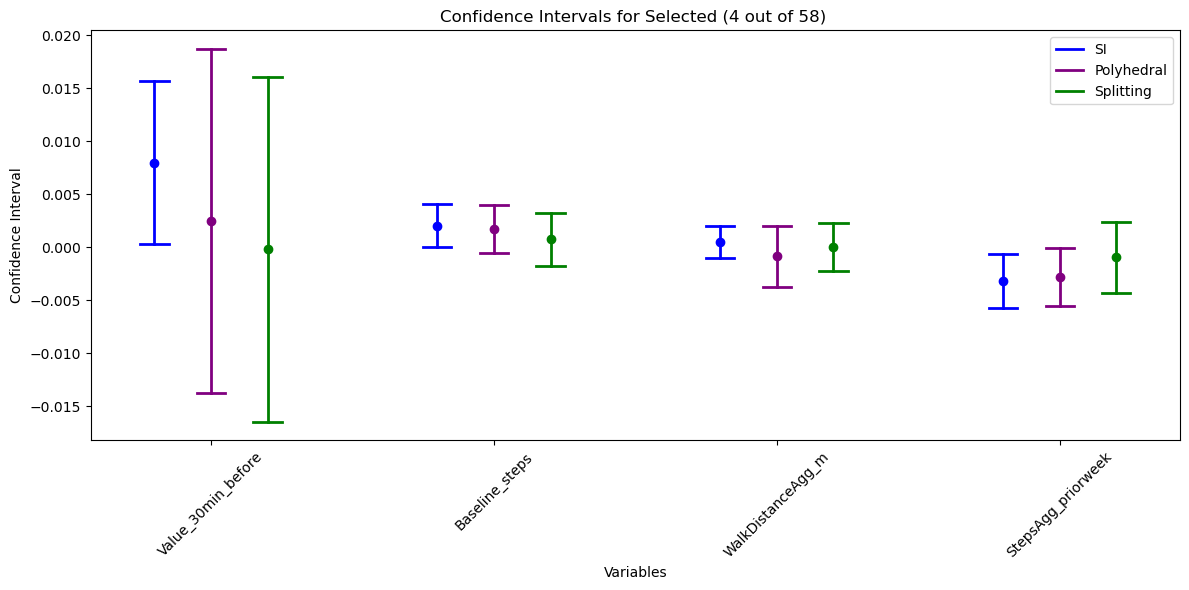

In [284]:
# Calculate midpoints for all intervals
midpoints1 = (intervals1_1[:, 0] + intervals1_1[:, 1]) / 2
midpoints2 = (intervals2_1[:, 0] + intervals2_1[:, 1]) / 2
midpoints3 = (intervals3_1[:, 0] + intervals3_1[:, 1]) / 2

# Plot settings
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.2  # Width for each set of CIs
x_positions = np.arange(len(snames))  # X positions for variables

# Plot each CI for method 1
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals2_1, midpoints2)):
    ax.plot([x_positions[i] - bar_width, x_positions[i] - bar_width], ci, color='blue', linewidth=2, label="SI" if i == 0 else "")
    ax.plot(x_positions[i] - bar_width, midpoint, 'o', color='blue')
    ax.plot([x_positions[i] - bar_width - 0.05, x_positions[i] - bar_width + 0.05], [ci[0], ci[0]], color='blue', linewidth=2)
    ax.plot([x_positions[i] - bar_width - 0.05, x_positions[i] - bar_width + 0.05], [ci[1], ci[1]], color='blue', linewidth=2)

# Plot each CI for method 2
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals1_1, midpoints1)):
    ax.plot([x_positions[i], x_positions[i]], ci, color='purple', linewidth=2, label="Polyhedral" if i == 0 else "")
    ax.plot(x_positions[i], midpoint, 'o', color='purple')
    ax.plot([x_positions[i] - 0.05, x_positions[i] + 0.05], [ci[0], ci[0]], color='purple', linewidth=2)
    ax.plot([x_positions[i] - 0.05, x_positions[i] + 0.05], [ci[1], ci[1]], color='purple', linewidth=2)

# Plot each CI for method 3
for i, (name, ci, midpoint) in enumerate(zip(snames, intervals3_1, midpoints3)):
    ax.plot([x_positions[i] + bar_width, x_positions[i] + bar_width], ci, color='green', linewidth=2, label="Splitting" if i == 0 else "")
    ax.plot(x_positions[i] + bar_width, midpoint, 'o', color='green')
    ax.plot([x_positions[i] + bar_width - 0.05, x_positions[i] + bar_width + 0.05], [ci[0], ci[0]], color='green', linewidth=2)
    ax.plot([x_positions[i] + bar_width - 0.05, x_positions[i] + bar_width + 0.05], [ci[1], ci[1]], color='green', linewidth=2)

# Set x-ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(snames)
ax.set_ylabel("Confidence Interval")
ax.set_xlabel("Variables")
ax.set_title("Confidence Intervals for Selected Parameters (4 out of 58)")

# Add legend
ax.legend()

plt.xticks(rotation=45)  # Rotate variable names if they overlap
plt.tight_layout()
plt.show()


In [216]:
np.sqrt(n)

124.66755792907793